# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

DatabaseError: ignored

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



DatabaseError: ignored

In [0]:
print(display.shape)
display.head()

AttributeError: ignored

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

TypeError: ignored

In [0]:
display['COUNT(*)'].sum()

TypeError: ignored

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:40<00:00, 2185.39it/s]


In [0]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8486145734786987), ('excellent', 0.8254724740982056), ('awesome', 0.8126799464225769), ('good', 0.8051372170448303), ('wonderful', 0.7845391035079956), ('terrific', 0.7798044085502625), ('perfect', 0.7387899160385132), ('fabulous', 0.7284591794013977), ('amazing', 0.7171012759208679), ('nice', 0.7082468867301941)]
[('greatest', 0.818374514579773), ('best', 0.7430814504623413), ('tastiest', 0.7042862772941589), ('nastiest', 0.6747569441795349), ('nicest', 0.6639612317085266), ('smoothest', 0.6293241381645203), ('horrible', 0.6276334524154663), ('disgusting', 0.6155544519424438), ('ive', 0.604020357131958), ('closest', 0.5992089509963989)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [03:52<00:00, 377.81it/s]

87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [41:05<00:00, 35.60it/s]


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
from scipy.sparse import csr_matrix
bow_train_2 = csr_matrix((bow_train_2, X_train_bow.indices, X_train_bow.indptr), shape=X_train_bow.shape)
bow_train_2.shape

(61441, 46446)

In [0]:
w1 = lr_l2.coef_ + 0.000001
w2 = model_2.coef_+0.000001

diff = w1-w2
change = diff*1.0/w1
percentage_change = change * 100
percentage_change = percentage_change[0]

In [0]:
for i in range(10, 101, 10):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))

 10th Percentile value : -0.01070
 20th Percentile value : -0.00456
 30th Percentile value : -0.00208
 40th Percentile value : -0.00054
 50th Percentile value : 0.00071
 60th Percentile value : 0.00205
 70th Percentile value : 0.00399
 80th Percentile value : 0.00750
 90th Percentile value : 0.02040
100th Percentile value : 321.28636


In [0]:
for i in range(90, 101, 1):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))

 90th Percentile value : 0.02040
 91th Percentile value : 0.02467
 92th Percentile value : 0.03112
 93th Percentile value : 0.04117
 94th Percentile value : 0.07542
 95th Percentile value : 0.17748
 96th Percentile value : 0.47728
 97th Percentile value : 0.95443
 98th Percentile value : 1.69985
 99th Percentile value : 2.94466
100th Percentile value : 321.28636


In [0]:
for i in range(1, 11, 1):
    print("{:.1f}th Percentile value :{:.5f}".format(i*1.0/10 + 99, np.percentile(percentage_change, i*1.0/10 + 99)))

99.1th Percentile value :3.10029
99.2th Percentile value :3.37590
99.3th Percentile value :3.56198
99.4th Percentile value :3.96524
99.5th Percentile value :4.60944
99.6th Percentile value :5.24354
99.7th Percentile value :6.54892
99.8th Percentile value :8.21432
99.9th Percentile value :30.16743
100.0th Percentile value :321.28636


In [0]:
dfp = pd.DataFrame(percentage_change, index = vectorizer.get_feature_names(), columns=['%Change'])
dfp.head(10)

,%Change
aa,0.003003
aaa,0.001529
aaaa,0.001350
aaaaa,0.005364
aaaaaaaaaaaa,-0.001833
aaaaaaaaaaaaaaa,0.002897
aaaaaaahhhhhh,-0.043844
aaaaaaarrrrrggghhh,0.001274
aaaaaawwwwwwwwww,-0.043844
aaaaah,0.004756


In [0]:
dfp = dfp[dfp['%Change'] >30]
dfp.shape

(77, 1)

In [0]:
dfp.sort_values(by='%Change', ascending=False, inplace=True)
dfp

,%Change
handbook,321.286357
healthcare,43.498094
tignor,30.167426
englishman,30.167426
cutlass,30.167426
restraints,30.167426
requisitioned,30.167426
privateers,30.167426
privateering,30.167426
portsmouth,30.167426


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

df = pd.DataFrame(data=lr_l2.coef_.reshape(-1,1), index=vectorizer.get_feature_names())
df.sort_values(by=0,ascending=False).head(10)

,0
great,0.429641
best,0.292430
good,0.279621
love,0.273456
delicious,0.243700
loves,0.209537
perfect,0.189165
nice,0.187151
excellent,0.183618
favorite,0.174307


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

df.sort_values(by = 0, ascending=True).head(10)

,0
not,-0.296107
disappointed,-0.166829
worst,-0.155670
terrible,-0.149740
awful,-0.140116
horrible,-0.138631
disappointing,-0.128390
weak,-0.117049
stale,-0.114866
disappointment,-0.113883


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation


from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(X_train_tf)
X_train_tf = tf_idf_vect.transform(X_train_tf) 
X_test_tf = tf_idf_vect.transform(X_test_tf) 

X_train_tf = StandardScaler(with_mean = False).fit_transform(X_train_tf)

X_test_tf = StandardScaler(with_mean = False).fit_transform(X_test_tf)

print(X_train_tf.shape)
print(X_test_tf.shape)

(61441, 1084181)
(26332, 1084181)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


Best HyperParameter:  {'C': 1}
Best Accuracy: 95.06%


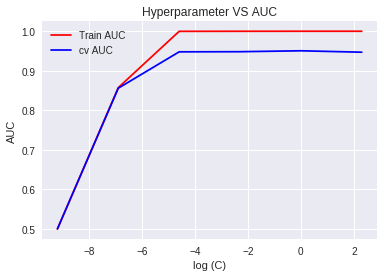

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs = GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tf,y_train_tf)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l1 = LogisticRegression(C=1, penalty= 'l1')
lr_l1.fit(X_train_tf,y_train_tf)
y_pred_l1 = lr_l1.predict(X_test_tf)

acc_tf_l1=(accuracy_score(y_test_tf, y_pred_l1)*100)
ps_tf_l1=(precision_score(y_test_tf, y_pred_l1)*100)
rc_tf_l1=(recall_score(y_test_tf, y_pred_l1)*100)
f1_tf_l1=(f1_score(y_test_tf, y_pred_l1)*100)
print("Accuracy on test set: %0.2f%%"%(acc_tf_l1))
print("Precision on test set: %0.2f%%"%(ps_tf_l1))
print("recall score on test set: %0.2f%%"%(rc_tf_l1))
print("f1 score on test set: %0.2f%%"%(f1_tf_l1))

Accuracy on test set: 92.19%
Precision on test set: 92.64%
recall score on test set: 98.52%
f1 score on test set: 95.49%


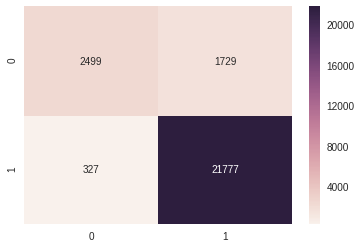

In [0]:
from sklearn.metrics import confusion_matrix
cm_l1 = pd.DataFrame(confusion_matrix(y_test_tf, y_pred_l1), range(2),range(2))
sns.heatmap(cm_l1, annot=True,fmt='g')

train auc =0.9999976027400255
test auc=0.9538621245537138


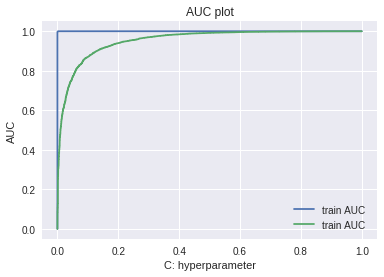

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l1.predict_proba(X_train_tf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l1.predict_proba(X_test_tf)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l1.predict_proba(X_train_tf)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l1.predict_proba(X_test_tf)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  6.6min finished


Best HyperParameter:  {'C': 100}
Best Accuracy: 91.40%


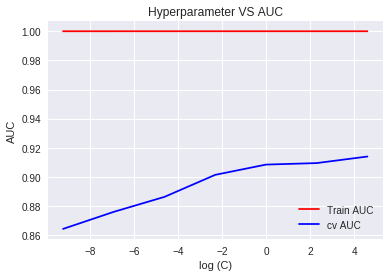

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(penalty='l2')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs= GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tf,y_train_tf)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l2 = LogisticRegression(C=100, penalty= 'l2')
lr_l2.fit(X_train_tf,y_train_tf)
y_pred_l2 = lr_l2.predict(X_test_tf)

acc_tf_l2=(accuracy_score(y_test_tf, y_pred_l2)*100)
ps_tf_l2=(precision_score(y_test_tf, y_pred_l2)*100)
rc_tf_l2=(recall_score(y_test_tf, y_pred_l2)*100)
f1_tf_l2=(f1_score(y_test_tf, y_pred_l2)*100)
print("Accuracy on test set: %0.2f%%"%(acc_tf_l2))
print("Precision on test set: %0.2f%%"%(ps_tf_l2))
print("recall score on test set: %0.2f%%"%(rc_tf_l2))
print("f1 score on test set: %0.2f%%"%(f1_tf_l2))

Accuracy on test set: 87.08%
Precision on test set: 86.74%
recall score on test set: 99.88%
f1 score on test set: 92.85%


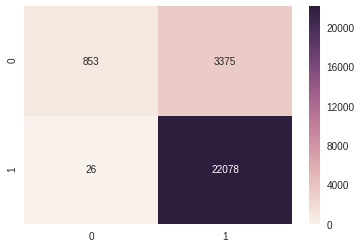

In [0]:
from sklearn.metrics import confusion_matrix
cm_l2 = pd.DataFrame(confusion_matrix(y_test_tf, y_pred_l2), range(2),range(2))
sns.heatmap(cm_l2, annot=True,fmt='g')

train auc =0.9999976027400255
test auc=0.9192743724428529


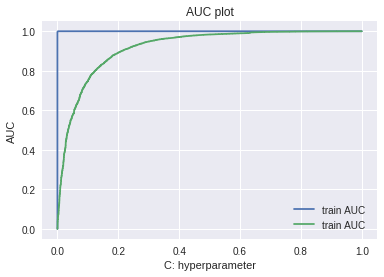

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l2.predict_proba(X_train_tf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l2.predict_proba(X_test_tf)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l2.predict_proba(X_train_tf)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l2.predict_proba(X_test_tf)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

df = pd.DataFrame(data=lr_l2.coef_.reshape(-1,1), index=tf_idf_vect.get_feature_names())
df.sort_values(by=0,ascending=False).head(10)

,0
great,0.235045
love,0.202398
good,0.187659
best,0.164955
dog,0.159484
use,0.159216
like,0.151761
delicious,0.128255
loves,0.116796
ordered,0.111644


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

df.sort_values(by=0,ascending=True).head(10)

,0
coffee,-0.347019
buy,-0.202620
liked,-0.142834
huge fan,-0.089821
not buy,-0.087653
not recommend,-0.083979
not worth,-0.082367
worst,-0.081326
would not,-0.079235
loving,-0.079169


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(np.array(sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

X_train_avg = StandardScaler(with_mean = False).fit_transform(X_train_avg)

X_test_avg = StandardScaler(with_mean = False).fit_transform(X_test_avg)

print(X_train_avg.shape)
print(X_test_avg.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min finished


Best HyperParameter:  {'C': 0.1}
Best Accuracy: 90.91%


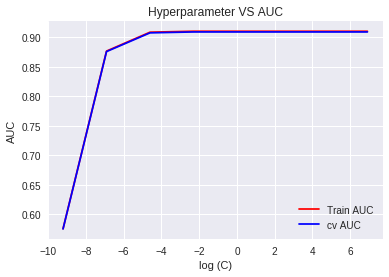

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(penalty='l1')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs = GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_avg,y_train_avg)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l1 = LogisticRegression(C=0.1, penalty= 'l1')
lr_l1.fit(X_train_avg,y_train_avg)
y_pred_l1 = lr_l1.predict(X_test_avg)

acc_avg_l1=(accuracy_score(y_test_avg, y_pred_l1)*100)
ps_avg_l1=(precision_score(y_test_avg, y_pred_l1)*100)
rc_avg_l1=(recall_score(y_test_avg, y_pred_l1)*100)
f1_avg_l1=(f1_score(y_test_avg, y_pred_l1)*100)
print("Accuracy on test set: %0.2f%%"%(acc_avg_l1))
print("Precision on test set: %0.2f%%"%(ps_avg_l1))
print("recall score on test set: %0.2f%%"%(rc_avg_l1))
print("f1 score on test set: %0.2f%%"%(f1_avg_l1))

Accuracy on test set: 89.07%
Precision on test set: 91.01%
recall score on test set: 96.50%
f1 score on test set: 93.68%


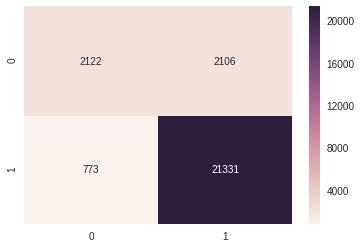

In [0]:
from sklearn.metrics import confusion_matrix
cm_l1 = pd.DataFrame(confusion_matrix(y_test_avg, y_pred_l1), range(2),range(2))
sns.heatmap(cm_l1, annot=True,fmt='g')

train auc =0.9100498717105885
test auc=0.9083974984856998


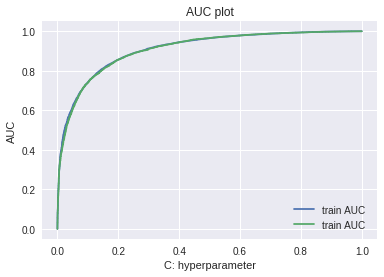

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l1.predict_proba(X_train_avg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l1.predict_proba(X_test_avg)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l1.predict_proba(X_train_avg)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l1.predict_proba(X_test_avg)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   17.9s finished


Best HyperParameter:  {'C': 1}
Best Accuracy: 90.91%


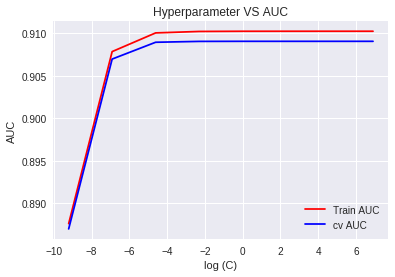

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(penalty='l2')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs = GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_avg,y_train_avg)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l2 = LogisticRegression(C=1, penalty= 'l2')
lr_l2.fit(X_train_avg,y_train_avg)
y_pred_l2 = lr_l2.predict(X_test_avg)

acc_avg_l2=(accuracy_score(y_test_avg, y_pred_l2)*100)
ps_avg_l2=precision_score(y_test_avg, y_pred_l2)*100
rc_avg_l2=recall_score(y_test_avg, y_pred_l2)*100
f1_avg_l2=f1_score(y_test_avg, y_pred_l2)*100
print("Accuracy on test set: %0.2f%%"%(acc_avg_l2))
print("Precision on test set: %0.2f%%"%(ps_avg_l2))
print("recall score on test set: %0.2f%%"%(rc_avg_l2))
print("f1 score on test set: %0.2f%%"%(f1_avg_l2))

Accuracy on test set: 89.10%
Precision on test set: 91.07%
recall score on test set: 96.48%
f1 score on test set: 93.70%


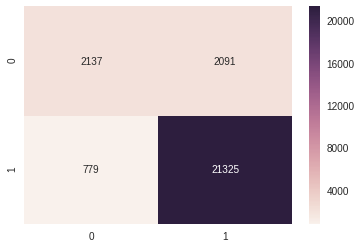

In [0]:
from sklearn.metrics import confusion_matrix
cm_l2 = pd.DataFrame(confusion_matrix(y_test_avg, y_pred_l2), range(2),range(2))
sns.heatmap(cm_l2, annot=True,fmt='g')

train auc =0.9100472178452524
test auc=0.9083824432261562


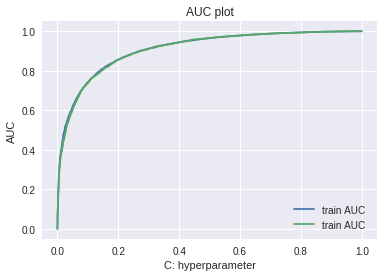

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l2.predict_proba(X_train_avg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l2.predict_proba(X_test_avg)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l2.predict_proba(X_train_avg)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l2.predict_proba(X_test_avg)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train_tw, X_test_tw, y_train_tw, y_test_tw = train_test_split(np.array(tfidf_sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

X_train_tw = StandardScaler(with_mean = False).fit_transform(X_train_tw)

X_test_tw = StandardScaler(with_mean = False).fit_transform(X_test_tw)


print(X_train_tw.shape)
print(X_test_tw.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   47.6s finished


Best HyperParameter:  {'C': 10}
Best Accuracy: 88.51%


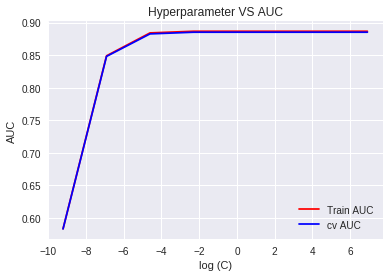

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs= GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tw,y_train_tw)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l1 = LogisticRegression(C=10, penalty= 'l1')
lr_l1.fit(X_train_tw,y_train_tw)
y_pred_l1 = lr_l1.predict(X_test_tw)

acc_tfavg_l1=(accuracy_score(y_test_tw, y_pred_l1)*100)
ps_tfavg_l1=(precision_score(y_test_tw, y_pred_l1)*100)
rc_tfavg_l1=(recall_score(y_test_tw, y_pred_l1)*100)
f1_tfavg_l1=(f1_score(y_test_tw, y_pred_l1)*100)
print("Accuracy on test set: %0.2f%%"%(acc_tfavg_l1))
print("Precision on test set: %0.2f%%"%(ps_tfavg_l1))
print("recall score on test set: %0.2f%%"%(rc_tfavg_l1))
print("f1 score on test set: %0.2f%%"%(f1_tfavg_l1))

Accuracy on test set: 87.99%
Precision on test set: 89.71%
recall score on test set: 96.80%
f1 score on test set: 93.12%


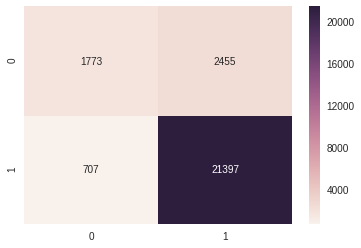

In [0]:
from sklearn.metrics import confusion_matrix
cm_l1 = pd.DataFrame(confusion_matrix(y_test_tw, y_pred_l1), range(2),range(2))
sns.heatmap(cm_l1, annot=True,fmt='g')

train auc =0.8863636864784062
test auc=0.8857902446883075


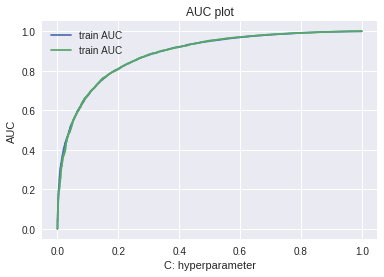

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l1.predict_proba(X_train_tw)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l1.predict_proba(X_test_tw)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l1.predict_proba(X_train_tw)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l1.predict_proba(X_test_tw)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   20.8s finished


Best HyperParameter:  {'C': 10}
Best Accuracy: 88.51%


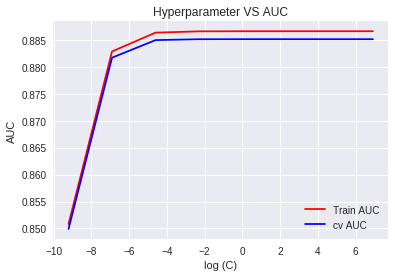

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(penalty='l2')
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001]} 
gs = GridSearchCV(lr,param_grid,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tw,y_train_tw)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

lines=plt.plot(np.log(param_grid['C']),train_auc,np.log(param_grid['C']), cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("log (C)")
plt.ylabel("AUC")
plt.title("Hyperparameter VS AUC")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
lr_l2 = LogisticRegression(C=10, penalty= 'l2')
lr_l2.fit(X_train_tw,y_train_tw)
y_pred_l2 = lr_l2.predict(X_test_tw)

acc_tfavg_l2=accuracy_score(y_test_tw, y_pred_l2)*100
ps_tfavg_l2=precision_score(y_test_tw, y_pred_l2)*100
rc_tfavg_l2=recall_score(y_test_tw, y_pred_l2)*100
f1_tfavg_l2=f1_score(y_test_tw, y_pred_l2)*100
print("Accuracy on test set: %0.2f%%"%(acc_tfavg_l2))
print("Precision on test set: %0.2f%%"%(ps_tfavg_l2))
print("recall score on test set: %0.2f%%"%(rc_tfavg_l2))
print("f1 score on test set: %0.2f%%"%(f1_tfavg_l2))

Accuracy on test set: 87.99%
Precision on test set: 89.70%
recall score on test set: 96.81%
f1 score on test set: 93.12%


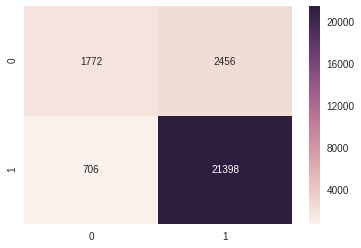

In [0]:
from sklearn.metrics import confusion_matrix
cm_l2 = pd.DataFrame(confusion_matrix(y_test_tw, y_pred_l2), range(2),range(2))
sns.heatmap(cm_l2, annot=True,fmt='g')

train auc =0.8863692771579563
test auc=0.8857941716820905


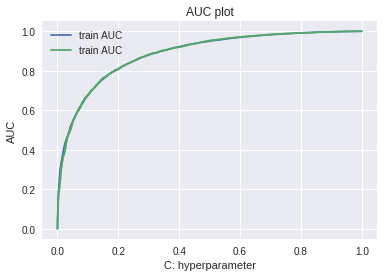

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l2.predict_proba(X_train_tw)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l2.predict_proba(X_test_tw)[:,1])
print("train auc ={}".format(roc_auc_score(y_train, lr_l2.predict_proba(X_train_tw)[:,1])))
print("test auc={}".format(roc_auc_score(y_test, lr_l2.predict_proba(X_test_tw)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

# [6] Conclusions

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL", "Hyperparameter","penalty", "Test AUC","F1 SCORE"]
x.add_row(["1", "BOW", "0.01", "L1","93%","94.89%"])
x.add_row(["", "BOW", "0.001", "L2","91.9%","94.90%"])
x.add_row(["2", "TFIDF","1", "L1","95.38%","95.49%"])
x.add_row(["", "TFIDF", "100", "L2","91.92%","92.85%"])
x.add_row(["3", "AVG W2V", "0.1", "L1","90.84%","93.70%"])
x.add_row(["", "AVG W2V", "1", "L2","90.84%","93.70%"])
x.add_row(["4", "TFIDF W2V", "10", "L1","88.58%","93.11%"])
x.add_row(["", "TFIDF W2V","10", "L2","88.57","93.11%"])
print(x)

+-------+-----------+----------------+---------+----------+----------+
| S.NO. |   MODEL   | Hyperparameter | penalty | Test AUC | F1 SCORE |
+-------+-----------+----------------+---------+----------+----------+
|   1   |    BOW    |      0.01      |    L1   |   93%    |  94.89%  |
|       |    BOW    |     0.001      |    L2   |  91.9%   |  94.90%  |
|   2   |   TFIDF   |       1        |    L1   |  95.38%  |  95.49%  |
|       |   TFIDF   |      100       |    L2   |  91.92%  |  92.85%  |
|   3   |  AVG W2V  |      0.1       |    L1   |  90.84%  |  93.70%  |
|       |  AVG W2V  |       1        |    L2   |  90.84%  |  93.70%  |
|   4   | TFIDF W2V |       10       |    L1   |  88.58%  |  93.11%  |
|       | TFIDF W2V |       10       |    L2   |  88.57   |  93.11%  |
+-------+-----------+----------------+---------+----------+----------+





1)Logestic regression is better than knn and naive bayes.

2)Best test auc of 95.38% is achieved by tfidf with L1 regularization.

3)Best F1 Score of 95.49% is also achieved by tfidf with L1 regularization.

4)BOW and tfidf are better than avg w2v and tfidf w2v.
